## Install Requires packages

In [36]:
pip install gradio

## Import necessary Libraries and Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_auc_score
import gradio as gr
import joblib
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the dataset
data = pd.read_csv('/content/Customer-survey-data.csv')

## Data Auditing

In [7]:
print(data.shape)

(10616, 5)


In [8]:
print(data.head())

   Customer  \
0         1   
1         2   
2         3   
3         4   
4         5   

   How satisfied were you with your overall delivery experience at Ali?                    1-5 where 1 = extremely dissatisfied and 5 = extremely satisfied  \
0                                                5.0                                                                                                          
1                                                3.0                                                                                                          
2                                                4.0                                                                                                          
3                                                5.0                                                                                                          
4                                                2.0                                                              

## Data preprocessing

In [9]:
# Rename columns for easier access
data.columns = [
    'Customer', 'OverallDeliveryExperience', 'FoodQuality', 'DeliverySpeed', 'OrderAccuracy']

In [10]:
# Encode target variable 'OverallDeliveryExperience'
data['Satisfaction'] = data['OverallDeliveryExperience'].apply(lambda x: 1 if x >= 4 else 0)

In [11]:
# Drop unnecessary columns
data = data.drop(columns=['Customer', 'OverallDeliveryExperience'])

In [12]:
# Encode categorical variables
le = LabelEncoder()
data['OrderAccuracy'] = le.fit_transform(data['OrderAccuracy'])

In [13]:
# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

## Splitting the Data

In [14]:
# Split features and target
X = data.drop('Satisfaction', axis=1)
y = data['Satisfaction']

In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# check if there is a imbalance in the dataset

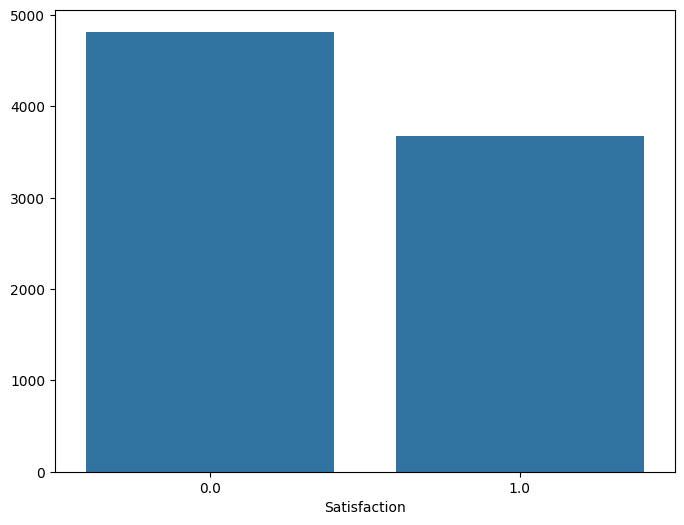

There is a imbalance in the dataset


In [22]:
# Check class distribution
class_counts = y_train.value_counts()

# Create bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.show()

print ("There is a imbalance in the dataset")

In [20]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [23]:
# Preprocessing
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

## creating pipelines

In [24]:
# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [25]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

## Defining the model and evaluation metrics

In [26]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Classifier": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [28]:
# Train and evaluate models
evaluation_metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'ROC-AUC': []
}

for name, model in models.items():
    print(f"\nTraining {name}...")

     # Create pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # Train model
    pipeline.fit(X_train_sm, y_train_sm)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

     # Store metrics
    evaluation_metrics['Model'].append(name)
    evaluation_metrics['Accuracy'].append(round(accuracy, 4))
    evaluation_metrics['Precision'].append(round(precision, 4))
    evaluation_metrics['Recall'].append(round(recall, 4))
    evaluation_metrics['F1-Score'].append(round(f1, 4))
    evaluation_metrics['ROC-AUC'].append(round(roc_auc, 4))

    # Print detailed classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))


Training Logistic Regression...

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      1203
         1.0       0.65      0.71      0.68       921

    accuracy                           0.71      2124
   macro avg       0.71      0.71      0.71      2124
weighted avg       0.71      0.71      0.71      2124


Training Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.82      0.76      0.79      1203
         1.0       0.72      0.78      0.75       921

    accuracy                           0.77      2124
   macro avg       0.77      0.77      0.77      2124
weighted avg       0.77      0.77      0.77      2124


Training Support Vector Classifier...

Classification Report for Support Vector Classifier:
              precision    recall  f1-score   support

         0.0       0.80      0.75      0.78     

## Evaluation Metrics Comparison




In [29]:
# Display evaluation metrics
metrics_df = pd.DataFrame(evaluation_metrics)
print("\nModel Comparison:")
print(metrics_df)


Model Comparison:
                       Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0        Logistic Regression    0.7095     0.6508  0.7123    0.6801   0.7295
1              Random Forest    0.7702     0.7163  0.7785    0.7461   0.8114
2  Support Vector Classifier    0.7533     0.6999  0.7546    0.7262   0.7666
3        K-Nearest Neighbors    0.7575     0.6956  0.7839    0.7371   0.7748
4                    XGBoost    0.7707     0.7174  0.7774    0.7462   0.8132


In [32]:
# Select best model (based on F1-Score)
best_model_name = metrics_df.loc[metrics_df['Accuracy'].idxmax(), 'Model']
best_model = models[best_model_name]

In [33]:
# Train final model with best performer
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_model)])
final_pipeline.fit(X_train_sm, y_train_sm)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['FoodQuality',
                                                   'DeliverySpeed',
                                                   'OrderAccuracy']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsamp...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [34]:
# Save the model and preprocessing pipeline
joblib.dump(final_pipeline, 'customer_satisfaction_model.pkl')
print(f"\nBest model ({best_model_name}) saved as 'customer_satisfaction_model.pkl'")


Best model (XGBoost) saved as 'customer_satisfaction_model.pkl'


## Deployment on Gradio

In [35]:
def predict_satisfaction(food_quality, delivery_speed, order_accuracy):
    # Create input data dictionary with all features, using default values where necessary
    input_data = {
        'FoodQuality': food_quality,
        'DeliverySpeed': delivery_speed,
        'OrderAccuracy': 1 if order_accuracy == 'Yes' else 0
    }

    # Convert to DataFrame
    input_df = pd.DataFrame([input_data])

    # Make prediction using pipeline
    prediction = final_pipeline.predict(input_df)[0]
    probability = final_pipeline.predict_proba(input_df)[0][1]

    return f"Satisfaction Prediction: {'Satisfied' if prediction == 1 else 'Dissatisfied'}\nSatisfaction Probability: {probability:.2%}"

# Define Gradio interface inputs with minimum features
inputs = [
    gr.Slider(minimum=1, maximum=5, step=1, label="Food Quality Rating"),
    gr.Slider(minimum=1, maximum=5, step=1, label="Delivery Speed Rating"),
    gr.Radio(choices=['Yes', 'No'], label="Was your order accurate?")
]

# Create and launch Gradio interface
interface = gr.Interface(
    fn=predict_satisfaction,
    inputs=inputs,
    outputs="text",
    title="Customer Satisfaction Prediction",
    description="Enter customer details to predict satisfaction level"
)

interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://55593c39ee93a45a71.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
